# Анализ источников новостей

Цель данного исследования: проанализировать источники новостных лент, сравнить рубрики, подумать над возможностью добавление\удаление категорий для проекта "Радар новостей рунета"

In [10]:
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt

In [11]:
import itertools
from collections import Counter
from string import punctuation
from razdel import tokenize

## Датасет iz. Предварительная обработка

Загрузим датасет iz. Одновременно сделаем преобразование даты из строки

In [12]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [13]:
data_iz = pd.read_csv('../data/iz.csv',
                      sep=',',
                      index_col=False,
                      escapechar='\\',
                      parse_dates=['date'],
                      date_parser=dateparse,
                      quotechar='\"', error_bad_lines=False)

b'Skipping line 61518: expected 17 fields, saw 20\n'


In [14]:
# Проверим преобразование
data_iz.dtypes

date           datetime64[ns]
url                    object
edition                object
topics                 object
authors                object
title                  object
text                   object
reposts_fb             object
reposts_vk             object
reposts_ok             object
reposts_twi            object
reposts_lj             object
reposts_tg             object
likes                  object
views                  object
comm_count             object
dtype: object

In [15]:
data_iz.shape

(86601, 16)

In [16]:
# Так выглядет датасет iz
data_iz.head()

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2017-01-24 18:24:00,https://iz.ru/699785/nataliia-portiakova/chtob...,-,Мир,Наталия Портякова,Чтобы помнили,В Европейском парламенте (ЕП) 24 января прошла...,-,-,-,-,-,-,-,-,-
1,2017-11-23 23:30:00,https://iz.ru/695670/izru-poluchil-premiiu-runeta,-,Пресс-релизы,NaN,IZ.ru получил премию Рунета,"IZ.ru стал победителем в номинации «Культура, ...",-,-,-,-,-,-,-,-,-
2,2017-11-25 23:49:47,https://iz.ru/675449/2017-11-25/chislo-mashin-...,-,Общество,NaN,Число машин с «мигалками» увеличили в Совфеде,"Президент России Владимир Путин подписал указ,...",-,-,-,-,-,-,-,-,-
3,2017-11-25 23:47:03,https://iz.ru/675448/2017-11-25/kudrin-zaiavil...,-,Экономика,NaN,Кудрин заявил о подготовке проекта развития РФ...,"Бывший министр финансов России, глава Центра с...",-,-,-,-,-,-,-,-,-
4,2017-11-25 23:46:48,https://iz.ru/675447/2017-11-25/gollandetc-kup...,-,Мир,NaN,Голландец купил акварель Гитлера за 75 центов,"Женщина, пожелавшая остаться неизвестной, отда...",-,-,-,-,-,-,-,-,-


In [17]:
# Выясним в каким столбцах есть пустые данные
data_iz.isnull().any()

date           False
url            False
edition        False
topics         False
authors         True
title          False
text            True
reposts_fb     False
reposts_vk     False
reposts_ok     False
reposts_twi    False
reposts_lj     False
reposts_tg     False
likes          False
views          False
comm_count     False
dtype: bool

In [18]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_iz['text'].isnull().sum())
data_iz[data_iz['text'].isnull()].head()

Кол-во строк с значением NaN в столбце "Text" =  1268


,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
330,2017-01-01 00:00:00,https://iz.ru/654049/video/odnopolye-braki,-,Общество,NaN,однополые браки,NaN,-,-,-,-,-,-,-,-,-
395,2017-09-12 22:43:46,https://iz.ru/644950/video/musor,-,Общество,NaN,Утилизация мусора,NaN,-,-,-,-,-,-,-,-,-
504,2017-09-12 18:28:25,https://iz.ru/644832/video/den-goroda-na-poklo...,-,Общество,NaN,День города на Поклонной горе. Александр Кибов...,NaN,-,-,-,-,-,-,-,-,-
506,2017-09-12 18:27:24,https://iz.ru/644830/video/den-goroda-na-poklo...,-,Общество,NaN,День города на Поклонной горе,NaN,-,-,-,-,-,-,-,-,-
581,2017-11-27 14:17:04,https://iz.ru/675938/video/proshchanie-s-dmitr...,-,Общество,NaN,Прощание с Дмитрием Хворостовским,NaN,-,-,-,-,-,-,-,-,-


In [19]:
#Удалим эти строки
data_iz.drop(data_iz[data_iz.text.isnull()].index, inplace=True)

In [20]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_iz['text'].isnull().sum())

Кол-во строк с значением NaN в столбце "Text" =  0


Посмотрим сколько элементов Nan в столбце авторов

In [21]:
print('Кол-во строк с значением NaN в столбце "authors" = ', data_iz['authors'].isnull().sum())

Кол-во строк с значением NaN в столбце "authors" =  61692


Как видим все значения авторов Nan. Можно не использовать данные столбец

Посмотрим, что в столбцах, которые содержат дефис, как обозначение пустых данных

In [22]:
def analysis_columns(columns):
    for column in columns:
        if column not in ['url', 'date', 'topics', 'authors', 'title', 'text']:
            yield(print(str(column) + ':', data_iz[column].unique()))

In [23]:
data_columns = list(analysis_columns(data_iz.columns))

edition: ['-']
reposts_fb: ['-']
reposts_vk: ['-']
reposts_ok: ['-']
reposts_twi: ['-']
reposts_lj: ['-']
reposts_tg: ['-']
likes: ['-']
views: ['-']
comm_count: ['-']


Все столюцы можно удалять

In [24]:
#  Проверим повторяющиеся тексты
print('Кол-во одинаковых текстов:',data_iz.text.duplicated().sum())

Кол-во одинаковых текстов: 22


In [25]:
data_iz = data_iz.drop_duplicates(subset='text')

In [26]:
data_iz.shape

(85311, 16)

## EDA

### Анализ дат

In [27]:
print('Минимальная дата в датасете:', data_iz.date.min())
print('Максимальная дата в датасете:', data_iz.date.max())

Минимальная дата в датасете: 2001-06-28 16:51:00
Максимальная дата в датасете: 2017-12-26 23:58:25


#### Распределение количества новостей по месяцам

In [28]:
# Вынесем месяц и год новости в отдельные столбцы
data_iz['month'] = data_iz.date.apply(lambda x: x.month)
data_iz['year'] = data_iz.date.apply(lambda x: x.year)

# Создадим отдельный датасет посчитаем количество новостей в разрезе месяца и года
df = data_iz.groupby(['year', 'month']).text.nunique().reset_index()

In [29]:
df.head()

,year,month,text
0,2001,6,1
1,2001,9,1
2,2001,10,8
3,2001,11,9
4,2001,12,4


In [30]:
df['month_year'] = df[['month', 'year']].apply(lambda x: '-'.join(['0'+str(x.month) if x.month<10 else str(x.month),
                                                                  str(x.year)]),
                                               axis =1)

In [31]:
df.columns = ['year', 'month', 'nunique_text', 'month_year']

In [32]:
# выберем только те месяцы, в которых количество новостей больше 10
df = df[df.nunique_text>10]

In [33]:
df[['month_year', 'nunique_text']].sort_values('nunique_text', ascending = False).head()

,month_year,nunique_text
71,07-2017,8979
75,12-2017,8866
72,09-2017,6112
73,10-2017,4003
69,05-2017,3618


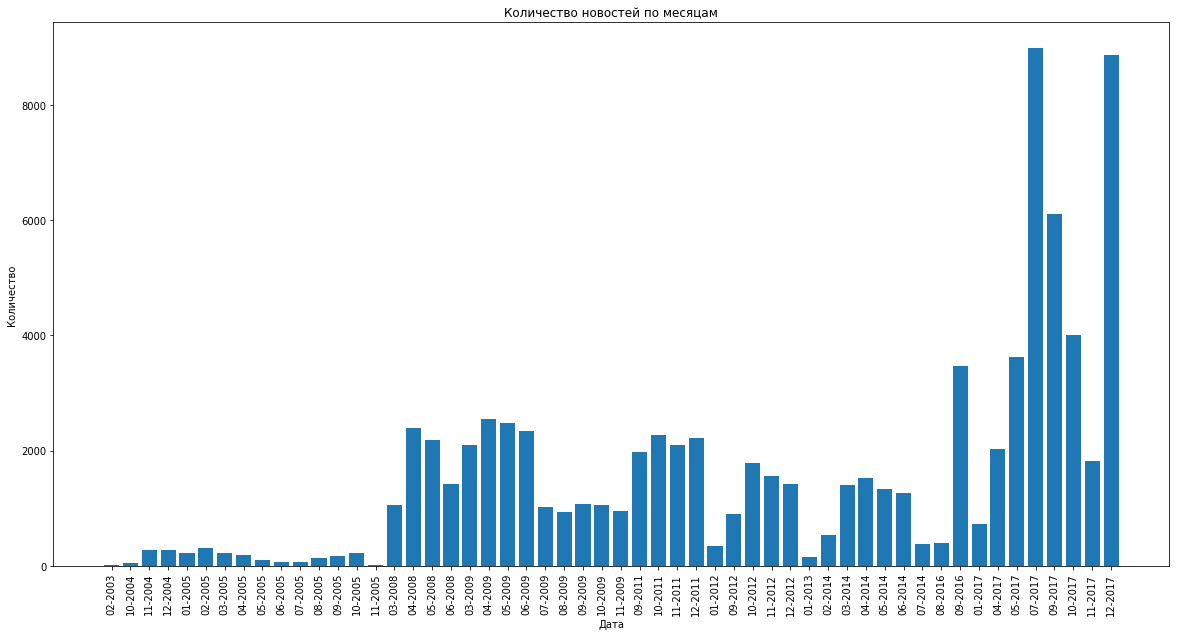

In [34]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x = df.month_year,
        height = df.nunique_text.values)
plt.xticks(rotation='vertical')
ax.set_title('Количество новостей по месяцам')
ax.set_ylabel('Количество')
ax.set_xlabel('Дата')
plt.show()

### Создание словаря для анализа

В данной части блокнота будет подготовлен словарь из всего множества слов во всем датасете. Для каждой новости будет выполнена токенизация. Затем будет собран словарь из всех токенов, очистка от знаков препинания, и после данных процедур создается два списка - один без удаления стоп-слов, второй с удалением. Анализ проводится по частоте вхождений для каждого списка

In [35]:
def create_dictionary(text):
    for news in text:
        tokens = list(tokenize(news.lower()))
        yield([_.text for _ in tokens])

In [36]:
data_iz.text = list(create_dictionary(data_iz.text.values))

In [37]:
# Соберем словарь из новостей для последующего анализа, без объединения повторяющихся слов
dictionary = list(itertools.chain.from_iterable(data_iz.text.values))

In [ ]:
# Соберем значки препинания, часть возьмем из готовой библиотеки, часть добавим свои

In [38]:
punctuation = list(punctuation)

In [39]:
punctuation += ['«','»','—','n','»,','».','–', '...']

In [50]:
garbage_words = ['nранее', 'nв', 'nпо', 'nтакже','u','n—', 'br', 'b']

In [51]:
# Словарь без удаления стопслов
dictionary_with_stopwords = [item for item in dictionary if item not in punctuation]

In [52]:
dictionary_with_stopwords = [item for item in dictionary_with_stopwords if item not in garbage_words]

In [53]:
stopwords_01 = open('../nlp/preprocessing/stopwords.txt', 'r', encoding='UTF-8')
stopwords_01 = stopwords_01.read().split('\n')
stopwords_02 = open('../nlp/preprocessing/stopwords_02.txt', 'r', encoding='UTF-8')
stopwords_02 = stopwords_02.read().split('\n')

In [54]:
stopwords = stopwords_01 + stopwords_02

In [55]:
# Словарь после удаления стопслов
dictionary_without_stopwords = [item for item in dictionary_with_stopwords if item not in stopwords]

### Аналитика по словам

#### 20 самых популярных слов без удаления стопслов

In [56]:
Counter(dictionary_with_stopwords).most_common(20)

[('в', 1022869),
 ('и', 622044),
 ('на', 438840),
 ('не', 290692),
 ('что', 273821),
 ('с', 258895),
 ('по', 233524),
 ('а', 115480),
 ('как', 109848),
 ('из', 107276),
 ('о', 106882),
 ('к', 105827),
 ('это', 99598),
 ('для', 97612),
 ('за', 94591),
 ('но', 86837),
 ('он', 78553),
 ('от', 77789),
 ('его', 75658),
 ('у', 69690)]

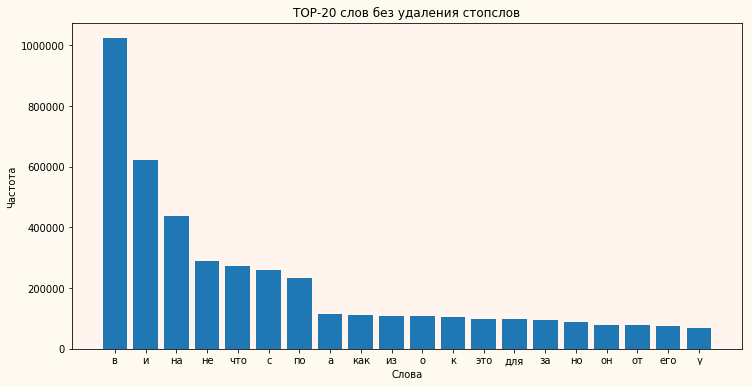

In [57]:
x = dict(Counter(dictionary_with_stopwords).most_common(20)).keys()
y = dict(Counter(dictionary_with_stopwords).most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

#### 20 самых популярных слов после удаления стопслов 

In [58]:
Counter(dictionary_without_stopwords).most_common(20)

[('россии', 64131),
 ('сша', 29664),
 ('рублей', 27389),
 ('заявил', 26928),
 ('словам', 26030),
 ('тыс', 24879),
 ('рф', 23086),
 ('известиям', 22699),
 ('млн', 20917),
 ('страны', 19524),
 ('сообщает', 18753),
 ('области', 17879),
 ('1', 17631),
 ('компании', 17313),
 ('глава', 17045),
 ('президента', 16422),
 ('власти', 15570),
 ('решение', 15271),
 ('сообщил', 15237),
 ('млрд', 14847)]

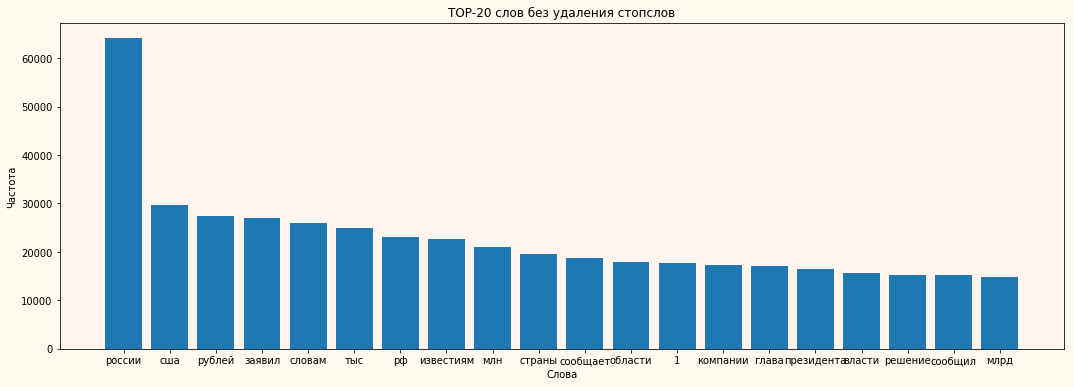

In [60]:
x = dict(Counter(dictionary_without_stopwords).most_common(20)).keys()
y = dict(Counter(dictionary_without_stopwords).most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

### Рубрики iz

In [62]:
# Считаем количество рубрик в датасете iz, а также выведем значения
print('Количество рубрик = ', data_iz.topics.unique().shape)
data_iz['topics'].unique()

Количество рубрик =  (33,)


array(['Мир', 'Пресс-релизы', 'Общество', 'Экономика', 'Спорт', 'Наука',
       'Политика', 'Культура', 'Армия', 'Страна', 'Авто', 'Интернет',
       'Образование', 'Потребительский рынок', 'Новости компаний',
       'День в истории', 'Туризм', 'Вкусно!', 'Россия - регионы',
       'Недвижимость', 'Китай', 'Art Briz', 'Здоровье', 'Стиль',
       'Инновации', 'Происшествия', 'Финансы', 'Транспорт',
       'Среда для жизни', 'Профсоюзы', 'Спецпроекты', 'День Победы',
       'Финансовая грамотность'], dtype=object)

In [63]:
data_iz.groupby('topics')['topics'].count().head()

topics
Art Briz          9
Авто             44
Армия          1150
Вкусно!           7
День Победы       2
Name: topics, dtype: int64

Тут надо разбираться, все ли рубрики нам нужны